# `TimeSeriesDataset` Sample

In [1]:
import numpy as np
import pandas as pd
from pytorch_forecasting import TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
import torch
from pytorch_forecasting.models.baseline import Baseline
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
import pytorch_lightning as pl
from pytorch_forecasting.models.temporal_fusion_transformer import TemporalFusionTransformer
from pytorch_forecasting.metrics.quantile import QuantileLoss
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorboard as tb
tf.io.gfile = tb.compat.tensorflow_stub.io.gfile

In [2]:
sample_data = pd.DataFrame(
    dict(
        time_idx=np.tile(np.arange(6), 3),
        target=np.array([0,1,2,3,4,5,20,21,22,23,24,25,40,41,42,43,44,45]),
        group=np.repeat(np.arange(3), 6),
        holidays = np.tile(['X','Black Friday', 'X','Christmas','X', 'X'],3),
    )
)
sample_data

,time_idx,target,group,holidays
0,0,0,0,X
1,1,1,0,Black Friday
2,2,2,0,X
3,3,3,0,Christmas
4,4,4,0,X
5,5,5,0,X
6,0,20,1,X
7,1,21,1,Black Friday
8,2,22,1,X
9,3,23,1,Christmas


In [3]:
# create the time-series dataset from the pandas df
dataset = TimeSeriesDataSet(
    sample_data,
    group_ids=["group"],
    target="target",
    time_idx="time_idx",
    max_encoder_length=2,  # Lookback period
    max_prediction_length=3,  # how many datapoints will be predicted
    time_varying_unknown_reals=["target"],
    static_categoricals=["holidays"],
    target_normalizer=None
)

In [4]:
# pass the dataset to a dataloader
dataloader = dataset.to_dataloader(batch_size=1)

In [5]:
#load the first batch
x, y = next(iter(dataloader))
print(x['encoder_target'])
print(x['groups'])
print('\n')
print(x['decoder_target'])

tensor([[40., 41.]])
tensor([[2]])


tensor([[42., 43., 44.]])


In [6]:
x

{'encoder_cat': tensor([[[2],
          [0]]]),
 'encoder_cont': tensor([[[40.],
          [41.]]]),
 'encoder_target': tensor([[40., 41.]]),
 'encoder_lengths': tensor([2]),
 'decoder_cat': tensor([[[2],
          [1],
          [2]]]),
 'decoder_cont': tensor([[[42.],
          [43.],
          [44.]]]),
 'decoder_target': tensor([[42., 43., 44.]]),
 'decoder_lengths': tensor([3]),
 'decoder_time_idx': tensor([[2, 3, 4]]),
 'groups': tensor([[2]]),
 'target_scale': tensor([[0., 1.]])}

In [7]:
y

(tensor([[42., 43., 44.]]), None)

# Demand Energy Forecasting Tutorial

### Data Preprocessing

In [8]:
data = pd.read_csv('LD2011_2014.txt', index_col=0, sep=';', decimal=',')
data.index = pd.to_datetime(data.index)
data.sort_index(inplace=True)
data.head(5)

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,...,MT_361,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370
2011-01-01 00:15:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-01 00:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-01 00:45:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-01 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-01 01:15:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
data = data.resample('1h').mean().replace(0., np.nan)  # aggregate to hourly data
earliest_time = data.index.min()
df = data[['MT_002', 'MT_004', 'MT_005', 'MT_006', 'MT_008' ]]  # will use only 5 customers

In [10]:
df

,MT_002,MT_004,MT_005,MT_006,MT_008
2011-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN
2011-01-01 01:00:00,NaN,NaN,NaN,NaN,NaN
2011-01-01 02:00:00,NaN,NaN,NaN,NaN,NaN
2011-01-01 03:00:00,NaN,NaN,NaN,NaN,NaN
2011-01-01 04:00:00,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...
2014-12-31 20:00:00,25.248933,186.483740,92.073171,340.773810,315.656566
2014-12-31 21:00:00,22.759602,162.093496,86.280488,319.940476,269.360269
2014-12-31 22:00:00,22.048364,161.077236,86.890244,314.732143,251.683502
2014-12-31 23:00:00,21.337127,161.585366,83.841463,308.035714,250.841751


In [11]:
earliest_time

Timestamp('2011-01-01 00:00:00', freq='H')

In [12]:
# prepare our dataset for the TimeSeriesDataset format

df_list = []

for label in df:
    
    ts = df[label]

    start_date = min(ts.fillna(method='ffill').dropna().index)
    end_date = max(ts.fillna(method='bfill').dropna().index)
    
    active_range = (ts.index >= start_date) & (ts.index <= end_date)
    ts = ts[active_range].fillna(0.)
    
    tmp = pd.DataFrame({'power_usage': ts})
    date = tmp.index
    
    tmp['hours_from_start'] = (date - earliest_time).seconds / 60 / 60 + (date - earliest_time).days * 24
    tmp['hours_from_start'] = tmp['hours_from_start'].astype('int')
    
    tmp['days_from_start'] = (date - earliest_time).days
    tmp['date'] = date
    tmp['consumer_id'] = label
    tmp['hour'] = date.hour
    tmp['day'] = date.day
    tmp['day_of_week'] = date.dayofweek
    tmp['month'] = date.month

    #stack all time series vertically
    df_list.append(tmp)

time_df = pd.concat(df_list).reset_index(drop=True)

# match results in the original paper
time_df = time_df[(time_df['days_from_start'] >= 1096)
                & (time_df['days_from_start'] < 1346)].copy()

In [13]:
time_df

,power_usage,hours_from_start,days_from_start,date,consumer_id,hour,day,day_of_week,month
17544,24.004267,26304,1096,2014-01-01 00:00:00,MT_002,0,1,2,1
17545,23.293030,26305,1096,2014-01-01 01:00:00,MT_002,1,1,2,1
17546,24.537696,26306,1096,2014-01-01 02:00:00,MT_002,2,1,2,1
17547,21.870555,26307,1096,2014-01-01 03:00:00,MT_002,3,1,2,1
17548,22.226174,26308,1096,2014-01-01 04:00:00,MT_002,4,1,2,1
...,...,...,...,...,...,...,...,...,...
128759,249.158249,32299,1345,2014-09-07 19:00:00,MT_008,19,7,6,9
128760,303.030303,32300,1345,2014-09-07 20:00:00,MT_008,20,7,6,9
128761,306.397306,32301,1345,2014-09-07 21:00:00,MT_008,21,7,6,9
128762,279.461279,32302,1345,2014-09-07 22:00:00,MT_008,22,7,6,9


### Exploratory Data Analysis

In [14]:
time_df[['consumer_id', 'power_usage']].groupby('consumer_id').mean()

,power_usage
consumer_id,
MT_002,27.472588
MT_004,120.573001
MT_005,50.958384
MT_006,183.387773
MT_008,248.884259


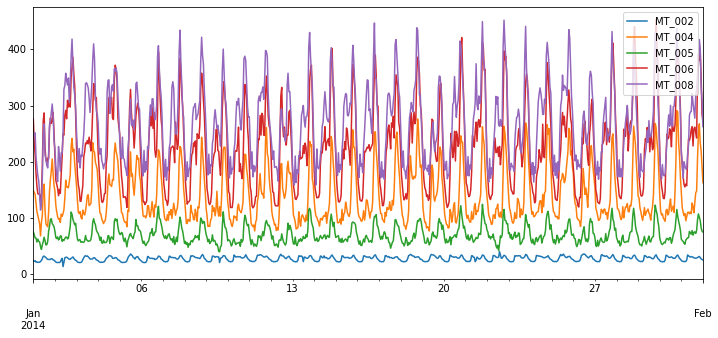

In [15]:
df.loc['2014-01-01 00:00:00': '2014-02-01 00:00:00'].plot(figsize=(12, 5));

### Create DataLoaders

In [16]:
#Hyperparameters
#batch size=64
#number heads=4, hidden sizes=160, lr=0.001, gr_clip=0.1

max_prediction_length = 24  # Next 24 hours
max_encoder_length = 7*24  # Previous 7 days
training_cutoff = time_df["hours_from_start"].max() - max_prediction_length

training = TimeSeriesDataSet(
    time_df[lambda x: x.hours_from_start <= training_cutoff],
    time_idx="hours_from_start",
    target="power_usage",
    group_ids=["consumer_id"],
    min_encoder_length=max_encoder_length // 2, 
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    static_categoricals=["consumer_id"],
    time_varying_known_reals=["hours_from_start","day","day_of_week", "month", 'hour'],
    time_varying_unknown_reals=['power_usage'],
    target_normalizer=GroupNormalizer(
        groups=["consumer_id"], transformation="softplus"
    ),  # we normalize by group
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
)

In [17]:
validation = TimeSeriesDataSet.from_dataset(training, time_df, predict=True, stop_randomization=True)

In [18]:
# create dataloaders for  our model
batch_size = 64 
# if you have a strong GPU, feel free to increase the number of workers  
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)

### Baseline Model

In [19]:
actuals = torch.cat([y for x, (y, weight) in iter(val_dataloader)])
baseline_predictions = Baseline().predict(val_dataloader)
(actuals - baseline_predictions).abs().mean().item()

C:\Users\johnw\miniconda3\envs\mds574\lib\site-packages\pytorch_lightning\utilities\parsing.py:262: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
C:\Users\johnw\miniconda3\envs\mds574\lib\site-packages\pytorch_lightning\utilities\parsing.py:262: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  rank_zero_warn(


25.139617919921875

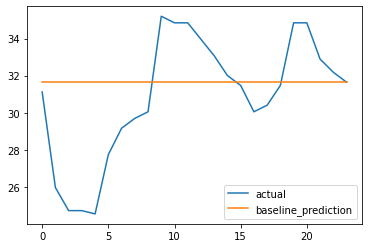

In [20]:
pd.DataFrame({"actual": actuals.numpy()[0], "baseline_prediction": baseline_predictions.numpy()[0]}).plot();

### Training the Temporal Fusion Transformer Model

In [21]:
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=5, verbose=True, mode="min")
lr_logger = LearningRateMonitor()
logger = TensorBoardLogger("lightning_logs")

In [22]:
trainer = pl.Trainer(
    max_epochs=45,
    accelerator='gpu',
    devices=1,
    enable_model_summary=True,
    gradient_clip_val=0.1,
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [23]:
tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.001,
    hidden_size=160,
    attention_head_size=4,
    dropout=0.1,
    hidden_continuous_size=160,
    output_size=7,  # there are 7 quantiles by default: [0.02, 0.1, 0.25, 0.5, 0.75, 0.9, 0.98]
    loss=QuantileLoss(),
    log_interval=10, 
    reduce_on_plateau_patience=4,
)

C:\Users\johnw\miniconda3\envs\mds574\lib\site-packages\pytorch_lightning\utilities\parsing.py:262: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
C:\Users\johnw\miniconda3\envs\mds574\lib\site-packages\pytorch_lightning\utilities\parsing.py:262: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  rank_zero_warn(


In [24]:
trainer.fit(tft, train_dataloader, val_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 20    
3  | prescalers                         | ModuleDict                      | 3.2 K 
4  | static_variable_selection          | VariableSelectionNetwork        | 313 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 734 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 628 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 103 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 103 K 
9  | static_context_initial_cell_lstm 

Sanity Checking: 0it [00:00, ?it/s]

C:\Users\johnw\miniconda3\envs\mds574\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
C:\Users\johnw\miniconda3\envs\mds574\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 4.393


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.520 >= min_delta = 0.0001. New best score: 3.874


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.381 >= min_delta = 0.0001. New best score: 3.493


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.068 >= min_delta = 0.0001. New best score: 3.424


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.175 >= min_delta = 0.0001. New best score: 3.249


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 5 records. Best score: 3.249. Signaling Trainer to stop.


### Load and Save the Best Model

In [25]:
best_model_path = trainer.checkpoint_callback.best_model_path

In [26]:
print(best_model_path)

lightning_logs\lightning_logs\version_1\checkpoints\epoch=9-step=4680.ckpt


In [27]:
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

C:\Users\johnw\miniconda3\envs\mds574\lib\site-packages\pytorch_lightning\utilities\parsing.py:262: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
C:\Users\johnw\miniconda3\envs\mds574\lib\site-packages\pytorch_lightning\utilities\parsing.py:262: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  rank_zero_warn(


In [28]:
torch.save(best_tft.state_dict(), 'best_tft_weights.pth')
torch.save(best_tft, 'best_tft.pth')

### Check Tensorboard

In [29]:
# Start tensorboard
%load_ext tensorboard
%tensorboard - logdir lightning_logs

ERROR: Failed to launch TensorBoard (exited with 2).
Contents of stderr:
usage: tensorboard [-h] [--helpfull] [--logdir PATH] [--logdir_spec PATH_SPEC]
                   [--host ADDR] [--bind_all] [--port PORT]
                   [--reuse_port BOOL] [--load_fast {false,auto,true}]
                   [--extra_data_server_flags EXTRA_DATA_SERVER_FLAGS]
                   [--grpc_creds_type {local,ssl,ssl_dev}]
                   [--grpc_data_provider PORT] [--purge_orphaned_data BOOL]
                   [--db URI] [--db_import] [--inspect] [--version_tb]
                   [--tag TAG] [--event_file PATH] [--path_prefix PATH]
                   [--window_title TEXT] [--max_reload_threads COUNT]
                   [--reload_interval SECONDS] [--reload_task TYPE]
                   [--reload_multifile BOOL]
                   [--reload_multifile_inactive_secs SECONDS]
                   [--generic_data TYPE]
                   [--samples_per_plugin SAMPLES_PER_PLUGIN]
                   [-

### Model Evaluation

In [30]:
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = best_tft.predict(val_dataloader)

#average p50 loss overall
print((actuals - predictions).abs().mean().item())
#average p50 loss per time series
print((actuals - predictions).abs().mean(axis=1))

6.699209690093994
tensor([ 1.0179,  7.5046,  2.3254, 10.3040, 12.3441])


### Plot Predictions on Validation Data

In [31]:
#Take a look at what the raw_predictions variable contains

raw_predictions, x = best_tft.predict(val_dataloader, mode="raw", return_x=True)
print(raw_predictions._fields)
# ('prediction', 
# 'encoder_attention', 
# 'decoder_attention', 
# 'static_variables', 
# 'encoder_variables', 
# 'decoder_variables', 
# 'decoder_lengths', 
# 'encoder_lengths')

print('\n')
print(raw_predictions['prediction'].shape)
#torch.Size([5, 24, 7])

# We get predictions of 5 time-series for 24 days.
# For each day we get 7 predictions - these are the 7 quantiles:
#[0.02, 0.1, 0.25, 0.5, 0.75, 0.9, 0.98]
# We are mostly interested in the 4th quantile which represents, let's say, the 'median loss'
# fyi, although docs use the term quantiles, the most accurate term are percentiles

('prediction', 'encoder_attention', 'decoder_attention', 'static_variables', 'encoder_variables', 'decoder_variables', 'decoder_lengths', 'encoder_lengths')


torch.Size([5, 24, 7])


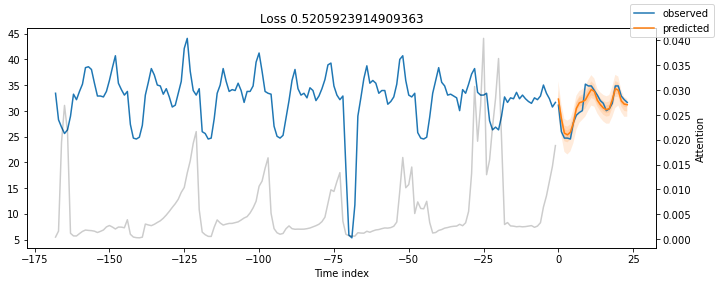

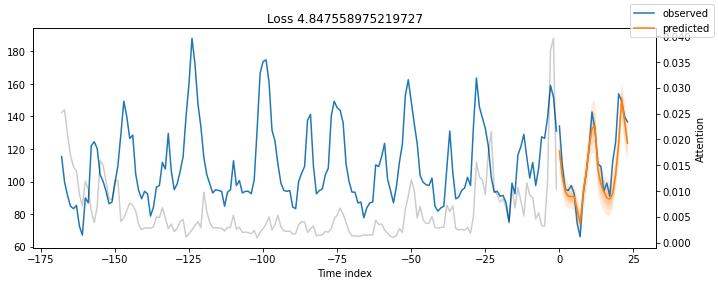

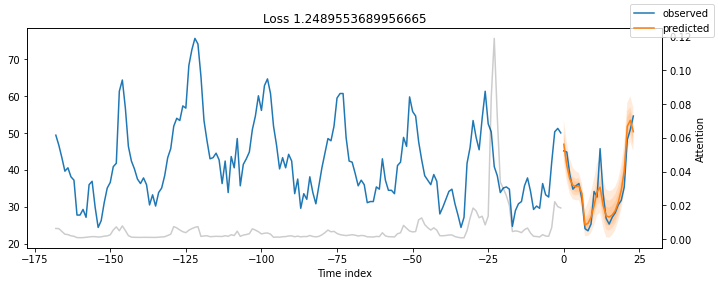

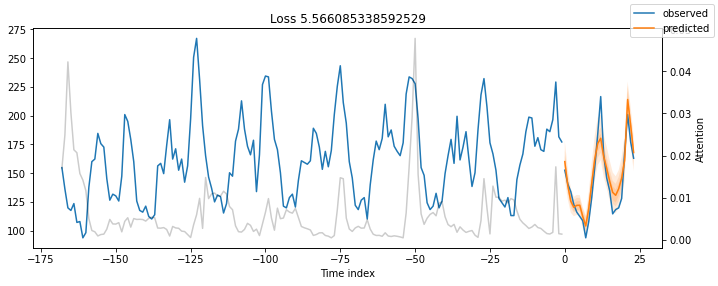

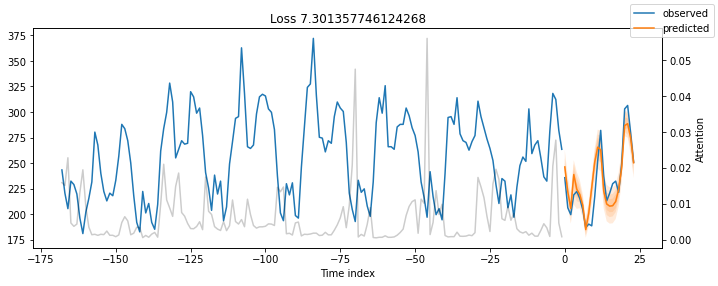

In [32]:
for idx in range(5):  # plot all 5 consumers
    fig, ax = plt.subplots(figsize=(10, 4))
    best_tft.plot_prediction(x, raw_predictions, idx=idx, add_loss_to_title=True,ax=ax)